In [5]:
import sys
!{sys.executable} -m pip install pyspark
!{sys.executable} -m pip install seaborn


In [6]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [7]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import udf,col

data = 'Final_database.csv'


In [8]:
spark = SparkSession.builder.master("local").appName("Music-Data-Analysis").getOrCreate()
spark

In [9]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

C:\Spark\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [10]:
df = spark.read.option("header",True).csv(data)
to_drop=['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in to_drop:
    df.drop(c).collect()
df.printSchema

<bound method DataFrame.printSchema of DataFrame[Country0: string, Uri: string, Popularity: string, Title: string, Artist: string, Album/Single: string, Genre: string, Artist_followers: string, Explicit: string, Album9: string, Release_date: string, Track_number: string, Tracks_in_album: string, danceability: string, energy: string, key: string, loudness: string, mode: string, speechiness: string, acoustics: string, instrumentalness: string, liveliness: string, valence: string, tempo: string, duration_ms: string, time_signature: string, Genre_new: string, Days_since_release: string, Released_after_2017: string, Explicit_false: string, Explicit_true: string, album31: string, compilation: string, single: string, bolero: string, boy band: string, country36: string, dance/electronic: string, else: string, funk: string, hip hop: string, house: string, indie: string, jazz: string, k-pop: string, latin: string, metal: string, opm: string, pop: string, r&b/soul: string, rap: string, reggae: st

In [11]:
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'speechiness', 'acoustics', 'instrumentalness', 'liveliness', 'valence', 'tempo', 'duration_ms', 
                      'time_signature', 'Days_since_release', 'n_words']
for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))

#### Popular Artist

In [12]:
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Popular Artists')

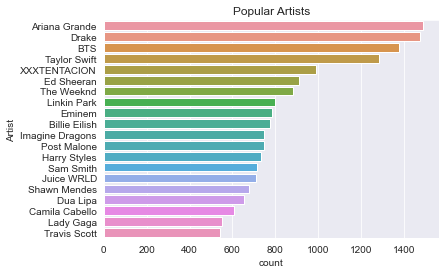

In [13]:
popular_artist = df.groupBy("Artist").count().orderBy("count",ascending=False).limit(20).toPandas()
sns.barplot(data=popular_artist,y='Artist',x='count').set_title('Popular Artists')

#### Popular Artist in India

In [14]:
df.registerTempTable("music_data")

C:\Spark\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


In [15]:
popular_artist_specific_country = spark.sql('SELECT Artist, ROUND(SUM(Popularity), 2) AS Populartiy \
                 FROM music_data \
                 WHERE UK == 1 \
                 GROUP BY Artist \
                 ORDER BY AVG(Popularity) DESC \
                 LIMIT 20'
               )
popular_artist_specific_country.show(20, truncate=False)
type(popular_artist_specific_country)

+--------------------------------------------+----------+
|Artist                                      |Populartiy|
+--------------------------------------------+----------+
|Calvin Harris - Dua Lipa                    |102479.25 |
|Dave - Burna Boy                            |100386.0  |
|Marshmello - Bastille                       |84639.15  |
|Keala Settle - The Greatest Showman Ensemble|82456.05  |
|Dave - Fredo                                |73267.8   |
|Calvin Harris - Sam Smith - Jessie Reyez    |70113.45  |
|DJ Khaled - Rihanna - Bryson Tiller         |66377.45  |
|Portugal. The Man                           |64179.35  |
|Tones And I                                 |125309.7  |
|Post Malone - Quavo                         |62164.7   |
|Regard                                      |61485.0   |
|Post Malone - 21 Savage                     |122706.65 |
|Loud Luxury - Brando                        |59066.55  |
|Zac Efron - Zendaya                         |59056.45  |
|MEDUZA - Good

pyspark.sql.dataframe.DataFrame

Text(0.5, 1.0, 'Popular Artists in a Country')

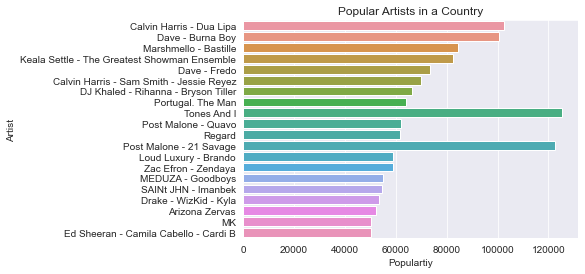

In [16]:
sns.barplot(data=popular_artist_specific_country.toPandas(),y='Artist',x='Populartiy').set_title('Popular Artists in a Country')

#### Songs released in a particular year

In [17]:
df.filter(f.year(df['Release_date'])==2018).select('Title','Artist','Release_date','Genre').distinct().show(10,truncate=False)

+----------------------+-----------------------------+------------+-----------------------+
|Title                 |Artist                       |Release_date|Genre                  |
+----------------------+-----------------------------+------------+-----------------------+
|hold me tight or don’t|Fall Out Boy                 |2018-01-19  |emo                    |
|global                |Lil Baby                     |2018-11-30  |atl hip hop            |
|sparare alla luna     |Salmo - Coez                 |2018-11-09  |italian hip hop        |
|borderline            |Ariana Grande - Missy Elliott|2018-08-17  |dance pop              |
|waste it on me        |Steve Aoki - BTS             |2018-10-25  |big room               |
|movement              |Hozier                       |2018-11-14  |irish singer-songwriter|
|re-up                 |Nines - Trapstar Toxic       |2018-04-20  |grime                  |
|something new         |Wiz Khalifa - Ty Dolla $ign  |2018-07-13  |hip hop      

#### Most Popular Genres

In [18]:
spark.sql('SELECT Genre,Count(*) as popularity_vote from music_data GROUP BY Genre ORDER BY popularity_vote DESC').show(10)

+--------------+---------------+
|         Genre|popularity_vote|
+--------------+---------------+
|     dance pop|          25351|
|         latin|           7591|
|           pop|           7146|
|         k-pop|           4053|
|           n-a|           3952|
|german hip hop|           3834|
|   atl hip hop|           3668|
|     francoton|           3279|
| dutch hip hop|           3257|
|      big room|           3095|
+--------------+---------------+
only showing top 10 rows



#### Most Popular Genres per decade

In [19]:
popular_genres = spark.sql('SELECT  \
                    ROUND(Year(Release_date),-1) AS Decade, \
                    Genre\
                FROM music_data \
                WHERE ROUND(Year(Release_date), -1) IS NOT NULL \
                GROUP BY Decade, Genre \
                ORDER BY COUNT(Genre) DESC \
                ') \
            .dropDuplicates(subset=['Decade']) \
            .orderBy('Decade') \
            .show()

+------+-------------------+
|Decade|              Genre|
+------+-------------------+
|  1900|vocal harmony group|
|  1930|        movie tunes|
|  1940|    adult standards|
|  1950|    adult standards|
|  1960|    adult standards|
|  1970|    adult standards|
|  1980|         album rock|
|  1990|         irish rock|
|  2000|  alternative metal|
|  2010|          dance pop|
|  2020|          dance pop|
+------+-------------------+



 #### Recommendation using cosine similarity

In [63]:
# Preprocessing
features = ['Artist', 'Genre']
df.na.fill(" ")
spark.sql('SELECT Artist, Genre, Popularity FROM music_data').show()


+--------------------+-----------------+------------------+
|              Artist|            Genre|        Popularity|
+--------------------+-----------------+------------------+
|        Paulo Londra|argentine hip hop|          31833.95|
|        Paulo Londra|argentine hip hop|               8.0|
|        Paulo Londra|argentine hip hop|           76924.4|
|        Paulo Londra|argentine hip hop| 849.6000000000001|
|        Paulo Londra|argentine hip hop|           20739.1|
|        Paulo Londra|argentine hip hop| 60264.19999999997|
|        Paulo Londra|argentine hip hop| 60131.15000000014|
|        Paulo Londra|argentine hip hop| 64081.30000000009|
|        Paulo Londra|argentine hip hop|             208.0|
|        Paulo Londra|argentine hip hop|           75636.9|
|        Paulo Londra|argentine hip hop| 69318.34999999998|
|        Paulo Londra|argentine hip hop|25361.250000000004|
|        Paulo Londra|argentine hip hop| 56380.40000000006|
|        Paulo Londra|argentine hip hop|

In [71]:
from pyspark.sql.functions import regexp_replace
recommend_df_copy= spark.read.option("header",True).csv(data)
recommend_df= recommend_df_copy.where("Country0 == 'Global'")

print(recommend_df_copy.count())
print(recommend_df.count())
print(recommend_df.distinct().count())
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

recommend_df = recommend_df.withColumn('Index', row_number().over(Window.orderBy(monotonically_increasing_id())))
recommend_df=recommend_df.withColumn('Genre', regexp_replace('Genre', 'n-a', ' '))
recommend_df.registerTempTable("recommend")
spark.sql('SELECT Index,Country0, Title,Artist, Genre, Popularity FROM recommend').show(50)

170633
5461
5461
+-----+--------+---------------------+--------------------+--------------------+------------------+
|Index|Country0|                Title|              Artist|               Genre|        Popularity|
+-----+--------+---------------------+--------------------+--------------------+------------------+
|    1|  Global|           adan y eva|        Paulo Londra|   argentine hip hop|          31833.95|
|    2|  Global|      it wont kill ya|The Chainsmokers ...|           dance pop|             418.0|
|    3|  Global|                 hymn|               Kesha|           dance pop|              56.0|
|    4|  Global|               arrows|        Foo Fighters|   alternative metal|              78.4|
|    5|  Global|    talking to myself|         Linkin Park|   alternative metal|            244.95|
|    6|  Global|                  icy|  Logic - Gucci Mane|   conscious hip hop|            316.65|
|    7|  Global|        club paradise|               Drake|    canadian hip hop| 88

In [139]:
from pyspark.sql.functions import concat,col,lit
r_df=recommend_df.withColumn("Combined_Features", (concat(col("Genre"), lit(" "), col("Artist"))))
def string_to_list(row):
    return row.split(' ')

from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, ArrayType

s_to_l = udf(lambda row: string_to_list(row),ArrayType(StringType()) )
r_df=r_df.withColumn("feature",s_to_l(col("Combined_Features")))
#r_df = df.withColumn("feature", convert_string_to_list("Combined_features"))
r_df.registerTempTable("updated_recommend")
spark.sql('SELECT Index,Title,Artist,Genre,Combined_Features, feature FROM updated_recommend').show(50)


C:\Spark\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


+-----+---------------------+--------------------+--------------------+--------------------+--------------------+
|Index|                Title|              Artist|               Genre|   Combined_Features|             feature|
+-----+---------------------+--------------------+--------------------+--------------------+--------------------+
|    1|           adan y eva|        Paulo Londra|   argentine hip hop|argentine hip hop...|[argentine, hip, ...|
|    2|      it wont kill ya|The Chainsmokers ...|           dance pop|dance pop The Cha...|[dance, pop, The,...|
|    3|                 hymn|               Kesha|           dance pop|     dance pop Kesha| [dance, pop, Kesha]|
|    4|               arrows|        Foo Fighters|   alternative metal|alternative metal...|[alternative, met...|
|    5|    talking to myself|         Linkin Park|   alternative metal|alternative metal...|[alternative, met...|
|    6|                  icy|  Logic - Gucci Mane|   conscious hip hop|conscious hip hop

In [132]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="feature", outputCol="vector")
model = cv.fit(r_df)
result = model.transform(r_df)

c_matrix=result.select('Index', 'feature', 'vector')
c_matrix.show()

+-----+--------------------+--------------------+
|Index|             feature|              vector|
+-----+--------------------+--------------------+
|    1|[argentine hip ho...|(2866,[99,178],[1...|
|    2|[dance pop, The C...|(2866,[0,1499],[1...|
|    3|  [dance pop, Kesha]|(2866,[0,245],[1....|
|    4|[alternative meta...|(2866,[17,205],[1...|
|    5|[alternative meta...|(2866,[17,44],[1....|
|    6|[conscious hip ho...|(2866,[9,1405],[1...|
|    7|[canadian hip hop...|(2866,[7,19],[1.0...|
|    8|[dance pop, Bruno...|(2866,[0,321],[1....|
|    9|[argentine indie,...|(2866,[2448,2525]...|
|   10|[dance pop, Ellie...|(2866,[0,297],[1....|
|   11|  [emo rap, Lil Xan]|(2866,[8,479],[1....|
|   12|[sertanejo pop, D...|(2866,[607,2797],...|
|   13|[chicago rap, Fam...|(2866,[10,582],[1...|
|   14|[atl hip hop, Lil...|(2866,[1,102],[1....|
|   15|[conscious hip ho...|(2866,[9,1107],[1...|
|   16|   [disco, Boney M.]|(2866,[388,1596],...|
|   17|[alternative r&b,...|(2866,[13,1355],[...|


In [140]:
import pandas as pd

pandas_df = c_matrix.toPandas()
pandas_df.head()

,Index,feature,vector
0,1,"[argentine hip hop, Paulo Londra]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,"[dance pop, The Chainsmokers - Louane]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,"[dance pop, Kesha]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[alternative metal, Foo Fighters]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,"[alternative metal, Linkin Park]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [154]:
import pandas as pd
matrix = r_df.select('Index','Title','Genre','Artist','Popularity','Combined_Features')
matrix = matrix.toPandas()
matrix.head()

,Index,Title,Genre,Artist,Popularity,Combined_Features
0,1,adan y eva,argentine hip hop,Paulo Londra,31833.95,argentine hip hop Paulo Londra
1,2,it wont kill ya,dance pop,The Chainsmokers - Louane,418.0,dance pop The Chainsmokers - Louane
2,3,hymn,dance pop,Kesha,56.0,dance pop Kesha
3,4,arrows,alternative metal,Foo Fighters,78.4,alternative metal Foo Fighters
4,5,talking to myself,alternative metal,Linkin Park,244.95,alternative metal Linkin Park


In [155]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(matrix["Combined_Features"])
print("Count Matrix:", count_matrix.toarray())

Count Matrix: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [156]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix)


In [161]:
song_user_likes = "so what"
def get_index_from_title(title):
    return matrix[matrix.Title == title]["Index"].values[0]
song_index = get_index_from_title(song_user_likes)
song_index

2978

In [162]:
songs_similar = list(enumerate(cosine_sim[song_index]))
sorted_similar_songs = sorted(songs_similar, key=lambda x:x[1], reverse=True)
def get_title_from_index(index):
    return matrix[matrix.Index == index]["Title"].values[0]
i=0
for songs in sorted_similar_songs:
    print(get_title_from_index(songs[0]))
    i+=1
    if i>20:
        break

keanu reeves
king of my city
dont come out the house
i say a little prayer
mary, did you know?
rain on me
right now
ta tum tum
oh my god
baebae
dusk till dawn - radio edit
solo pienso en ti
controlla
billie jean
die for me
28 liter
runaway
i warned myself
bad and boujee
malediven
happy now
